In [2]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline

## Implicit Copulae: Gauss- and T-Copula

In [3]:
from scipy.stats import multivariate_t, multivariate_normal, t, norm

In [4]:
class gauss_copula():
    def __init__(self, **kwargs):
        self.random_state = kwargs['random_seed']
        self.correl = kwargs['correl']
        self.correl_mat = np.array([[1.0, self.correl], [self.correl, 1.0]])
    
    def rvs(self, size):
        np.random.seed(self.random_state)
        norm_rvs = multivariate_normal(cov=self.correl_mat).rvs(size=size)
        res = norm.cdf(norm_rvs)
        return res
        
    def density(self, u, v):
        multi_norm_frzn = multivariate_normal(cov=self.correl_mat)
        ninv_u = norm.ppf(u)
        ninv_v = norm.ppf(v)
        density = multi_norm_frzn.pdf(np.c_[ninv_u, ninv_v])/(norm.pdf(ninv_u) * norm.pdf(ninv_v))
        return density

In [5]:
class t_copula():
    def __init__(self, **kwargs):
        self.random_state = kwargs['random_seed']
        self.correl = kwargs['correl']
        self.correl_mat = np.array([[1.0, self.correl], [self.correl, 1.0]])
        self.dof = kwargs['dof']
        self.t_frzn = t(self.dof)
        self.multi_t_frzn = multivariate_t(shape=self.correl_mat, df = self.dof)
    
    def rvs(self, size):
        np.random.seed(self.random_state)
        x = self.multi_t_frzn.rvs(size=size)
        res = self.t_frzn.cdf(x)
        return res
        
    def density(self, u, v):
        ninv_u = self.t_frzn.ppf(u)
        ninv_v = self.t_frzn.ppf(v)
        density = self.multi_t_frzn.pdf(np.c_[ninv_u, ninv_v])/(self.t_frzn.pdf(ninv_u) * self.t_frzn.pdf(ninv_v))
        return density        

In [6]:
kwargs = {'random_seed': 10, 'correl': 0.7, 'dof': 4}

In [7]:
gauss_cp = gauss_copula(**kwargs)
t_cp = t_copula(**kwargs)

### Density of Implicit Copulae

In [8]:
a = np.linspace(0.01, 0.99, 30)
x, y = np.meshgrid(a, a)

In [9]:
z = t_cp.density(x.ravel(), y.ravel()).reshape(x.shape)
np.ceil(z.max())

22.0

In [10]:
ts=kwargs['correl']

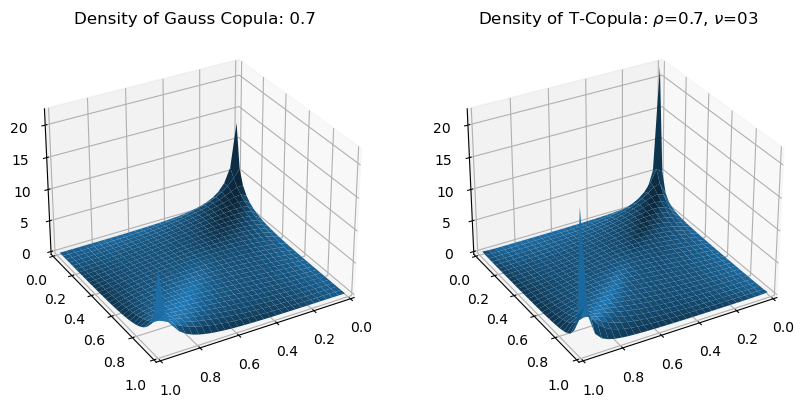

In [11]:
densG = gauss_cp.density(x.ravel(), y.ravel()).reshape(x.shape)
densT = t_cp.density(x.ravel(), y.ravel()).reshape(x.shape)
#plot 3D
fig = plt.figure(figsize=(10,6))
#ax = plt.axes(projection='3d')
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, densG)
ax1.set_zlim3d(0, np.ceil(densT.max()))
ax1.set_ylim3d(0, 1)
ax1.set_xlim3d(0, 1)
ax1.set_title(f'Density of Gauss Copula: {ts}')
ax1.view_init(30,60)
#---------------------------------------------------
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, densT)
ax2.set_zlim3d(0, np.ceil(densT.max()))
ax2.set_ylim3d(0,1)
ax2.set_xlim3d(0,1)
ax2.set_title(f'Density of T-Copula: $\\rho$={ts}, $\\nu$=03')
ax2.view_init(30,60)

Contour of the density functions

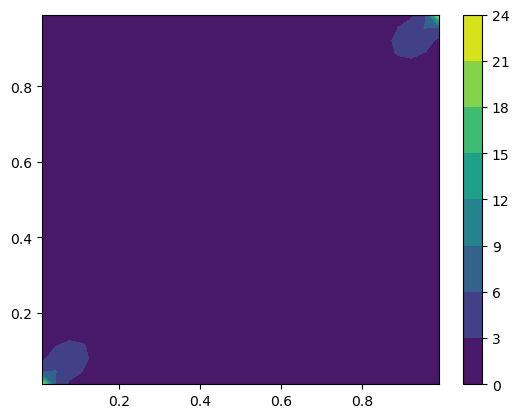

In [12]:
plt.contourf(x, y, densT)
plt.colorbar()

**Copulas Plotting**

In [13]:
gaussU = gauss_cp.rvs(5000)
tU = t_cp.rvs(5000)

In [14]:
np.corrcoef(gaussU[:,0], gaussU[:,1])

array([[1.        , 0.69102117],
       [0.69102117, 1.        ]])

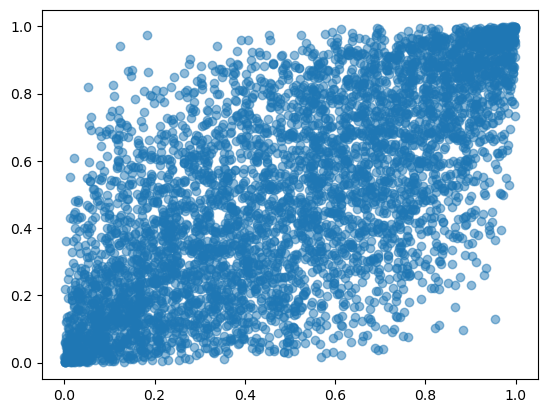

In [15]:
plt.scatter(gaussU[:,0], gaussU[:,1], alpha=0.5)

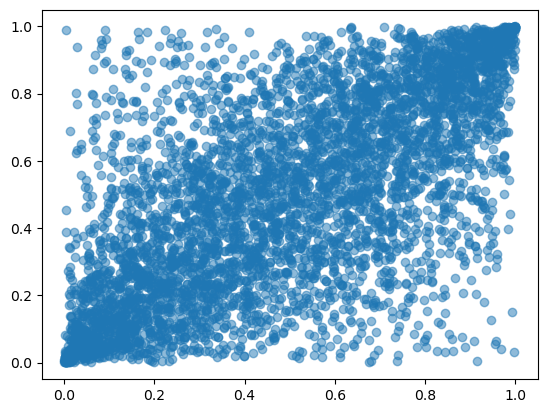

In [16]:
plt.scatter(tU[:,0], tU[:,1], alpha=0.5)

**TODO: Alternative simulation via Cholesky decomposition**

## Explicit Copulae: 

**Gumble copula**

$C(u) = e^{-(\sum_{i=1}^d (-ln u_i)^{-\theta} )^{-\frac{1}{\theta}}}$

$\lambda_u^{Gu^\theta} = 2 - 2^{\theta},\ \theta > 1$

**Clayton copula**

$C(u) = \left(\sum_{i=1}^d u_i^{-\theta} +1 -d  \right)^{-\frac{1}{\theta}} $

$\lambda_l^{Gu^{\theta}} = 2^{-\frac{1}{\theta}},\ \theta > 0$



**Frank copula**

$C(u) = -\frac{1}{\theta} \ln \left(1 + \frac{\prod_{i=1}^{2} (e^{-\theta \  u_i}-1)}{e^{-\theta}-1} \right)$

* *generator*

$ \hat{G}(t) = \phi^{-1}(t) = -\frac{1}{\theta} \ln \left(1 - (1-e^{-\theta}) e^{-t} \right)$

* *simulation*

Simulate $V$ a discrete rv with $\mathbb{P}(V=k) = \frac{(1-e^{\theta})^k}{k \theta},\ k=1, 2,...$ and $\theta >0$. Algorithm:

- Generate $U \sim \mathcal{U}(0,1)$, set $i = 1$
- $p_k = \mathbb{P}(V=k) = \frac{(1- e^{-\theta})^k}{k \theta},\ k = 1, 2,... $, $\theta > 0$
- $ P = [p_0=0, p_1, p_1+p_2, ..., \sum p_i]$
- $ P[k-1] \le u < P[k] \implies V = k$

In [17]:
from scipy.stats import levy_stable
from scipy.stats import gamma

In [18]:
class archimedean_copula():
    def __init__(self):
        pass          
            
    def C(self, u):
        if np.any(u>=1) or np.any(u<=0):
            raise ValueError('u must be in (0,1)')
        return self.generator(np.sum(self.generator_inv(u)))

In [19]:
class gumbel(archimedean_copula):
    def __init__(self, paras):
        super().__init__()
        self.correl_mat = paras['correl_mat']
        self.theta = paras['theta']
        self.seed = paras['random_seed']
    ##
    def generator(self, t): # generator = phi_inverse = Laplace transform 
        return np.exp(-t**(1/self.theta))
    def generator_inv(self, t): # inverse of the generator
        return (-np.log(t))**self.theta
    ##
    def c(self, u):
        
        
        dens = 0
        
        return dens
    
    ##
    @property
    def upper_tail_dependence(self): # upper tail dependence coefficient!!
        return 2 - 2**(1/self.theta)
    
    def rvs(self, n_sim):
        n_dim = len(self.correl_mat)
        ##
        stable_dist = levy_stable.rvs(alpha=1/self.theta, beta=1, scale=(np.cos(np.pi/(2 * self.theta)))**self.theta,\
                                 size=n_sim, random_state=self.seed[0])
        stable_dist = np.tile(stable_dist, (n_dim, 1)).T

        np.random.seed(self.seed[1])
        uniform_x = np.random.uniform(0, 1, size=[n_sim, n_dim])

        out = self.generator(-np.log(uniform_x)/stable_dist)
        return out

In [20]:
class clayton(archimedean_copula):
    def __init__(self, paras):
        super().__init__()
        self.correl_mat = paras['correl_mat']
        self.theta = paras['theta']
        self.seed = paras['random_seed']
    
    ##
    def generator(self, t):
        if np.any(t < 0):
            raise ValueError('argument must be positive')
        return (1 + t)**(-1/self.theta)
    
    def generator_inv(self, t):
        return t**(-self.theta) - 1
    ###
    
    @property
    def lower_tail_dependence(self):
        return 2**(-1/self.theta)
    
    # generate random samples
    def rvs(self, n_sim):
        n_dim = len(self.correl_mat)
        ##
        V = gamma.rvs(a=1/self.theta, size=n_sim, random_state=self.seed[0])
        V = np.tile(V, (n_dim,1)).T
        ##
        np.random.seed(self.seed[1])
        X = np.random.uniform(0, 1, size= [n_sim, n_dim])
        
        out = self.generator(-np.log(X)/V)
        return out

**Frank copula**

In [21]:
class frank(archimedean_copula):
    def __init__(self, paras):
        super().__init__()
        self.correl_mat = paras['correl_mat']
        self.theta = paras['theta']
        self.seed = paras['random_seed']
    
    ##
    def generator(self, t):
        if np.any(t < 0):
            raise ValueError('argument must be positive')
        return -1/self.theta * np.log(1 - (1 - np.exp(-self.theta)) * np.exp(-t))
    
    #def generator_inv(self, t):
    #    return t**(-self.theta) - 1
    ###
    
#     @property
#     def lower_tail_dependence(self):
#         return 2**(-1/self.theta)
    
    # generate random samples
    def rvs(self, n_sim):
        n_dim = len(self.correl_mat)
        ##
#         M = self.range_cap
#         prob = self.prob_mass(M)
#         np.random.seed(self.seed[0])
#         U = np.random.uniform(0, 1, size = n_sim)
#         V = np.ones(len(U))
#         V[U<=prob[0]] = 1
#         for i in range(1,len(prob)):
#             V[(prob[i]>=U)&(prob[i-1]<U)] = i+1
        ##
        np.random.seed(self.seed[0])
        probabilities = np.array([(1 - np.exp(-self.theta))**k / (self.theta * k) for k in range(1, 10000000)])
        probabilities /= probabilities.sum()  # Normalize to sum to 1
        V = np.random.choice(np.arange(1, 10000000), size=n_sim, p=probabilities)
        V = np.tile(V, (n_dim,1)).T
        ##
        np.random.seed(self.seed[1])
        X = np.random.uniform(0, 1, size= [n_sim, n_dim])
        
        out = self.generator(-np.log(X)/V)
        return out
    
    def prob_mass(self, M):
        i = np.arange(1, M+1, 1)
        p = ((1 - np.exp(-self.theta))**i)/(i * self.theta)
        return p.cumsum()
    #####
    @property
    def range_cap(self):
        m = 1_000_000
        while (self.prob_mass(m)[-1] < 1-1e-4):
            m += 1
        return m    

*experiment*

In [22]:
def prob_mass(M):
    i = np.arange(1, M+1, 1)
    p = ((1 - np.exp(-theta))**i)/(i * theta)
    return p.cumsum()
def range_cap():
    m = 1000_0000
    while (prob_mass(m)[-1] < 1-1e-4):
        m += 1
    return m 

In [23]:
u = np.random.uniform(0, 1, size=100)
np.argsort(u)

array([93, 46, 77, 13, 80, 30, 99, 67, 42, 86, 28, 36, 78, 72, 17, 76, 21,
       66, 20, 37, 22, 26, 65, 63, 14, 27, 61,  7, 64, 31, 41, 83,  9, 81,
        3, 53, 71,  1, 10, 44, 92, 52, 73, 75,  5, 96, 91, 16,  2, 68, 94,
       87, 23, 69, 40,  6, 35, 98, 62,  0, 89,  4, 74, 57, 51, 48, 47, 39,
       43, 25, 59, 82, 58, 34, 15, 29, 85, 88, 90, 49, 11, 50, 19, 95, 24,
       79, 54,  8, 33, 60, 38, 56, 55, 18, 70, 32, 12, 84, 97, 45],
      dtype=int64)

In [24]:
theta = 15
prob_mass(1000_000)

array([0.06666665, 0.09999996, 0.12222216, ..., 0.94058091, 0.94058096,
       0.94058101])

In [25]:
rho = 0.4
corr_mat = np.array([[1, rho], [rho, 1]])
##
seed = [10, 42]
parms = {'theta': 5,
        'correl_mat':corr_mat,
        'random_seed':seed}


In [26]:
frank_cp = frank(parms)

In [27]:
u = frank_cp.rvs(2000)

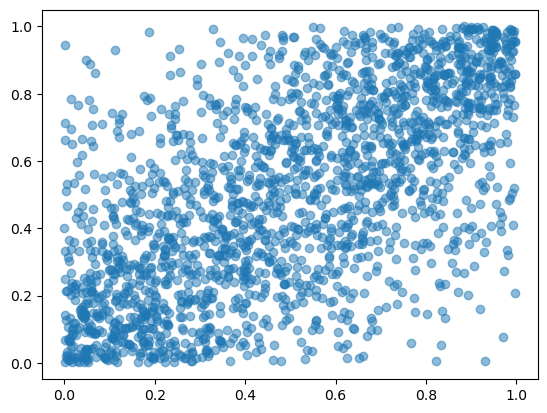

In [28]:
plt.scatter(u[:,0], u[:,1], alpha=0.5)

In [29]:
gumbel_cp = gumbel(parms)

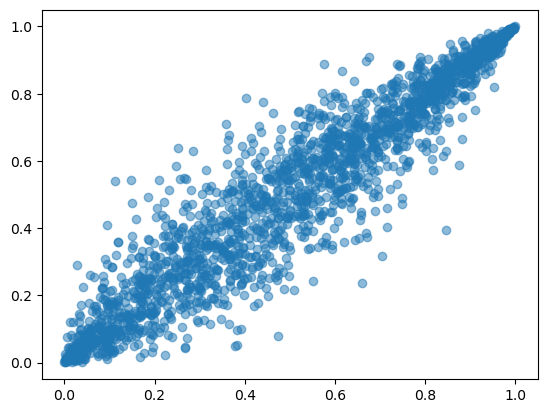

In [30]:
u = gumbel_cp.rvs(2000)
plt.scatter(u[:,0], u[:, 1], alpha=0.5)

In [31]:
gumbel_cp.upper_tail_dependence

0.8513016450029649

In [32]:
clayton_cp = clayton(parms)

In [33]:
cl = clayton_cp.rvs(2000)

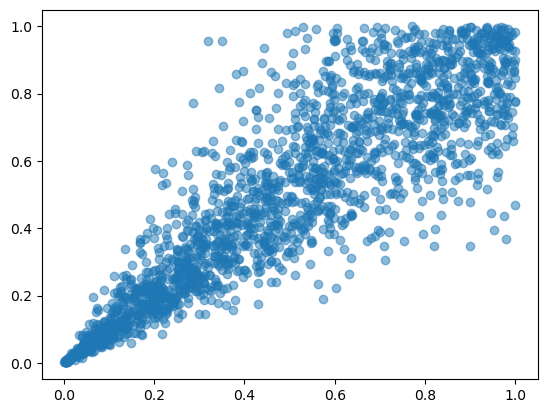

In [34]:
plt.scatter(cl[:,0], cl[:,1], alpha=0.5)

**Conditional Sampling**: For Frank copula, the Laplace based simulation is not quite feasible for sizable $\theta$. Resort to conditional sampling instead:

* *Conditional copula:*
    $\mathbb{P}(V \le v| U = u) = \lim_{\delta \to 0} \frac{\mathbb{P}(U\le u + \delta,\  V \le v) - \mathbb{P}(U\le u,\  V \le v) }{\delta} = \frac{\partial C(u,v)}{\partial u} = :C_u(v)$

*Simulation*:

- Step 1: Generate $U, W \sim \mathcal{U}(0,1)$, $U$ and $W$ are independent.
- Step 2: Set $V = C^{\leftarrow}_U(W)$. Then $C$ is the CDF of $(U, V)$.

*Proof*:

\begin{align}
\mathbb{P}(U \le u,\ V\le v) & = \mathbb{P}(U \le u,\ W \le C_U(v))\\
 & = \int_0^1 \mathbb{P}(U \le u,\ W \le C_U(v) | U = z) dz \\
 & = \int_0^u \mathbb{P}(W \le C_z(v) | U = z) dz \\
  & = \int_0^u C_z(v) dz = C(u, v) - C(0, v) = C(u,v).
\end{align}

In [90]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def frank_copula_partial_inverse(w, u):
    res = -1/theta * np.log(1 + w*(np.exp(-theta)-1)/(w + (1-w)*np.exp(-theta*u)))
    return res

In [107]:
theta = 30
N = 3000
X = np.random.uniform(0, 1, size=(N,2))

In [108]:
u = X[:,0]
w = X[:,1]

In [109]:
v = frank_copula_partial_inverse(w, u)

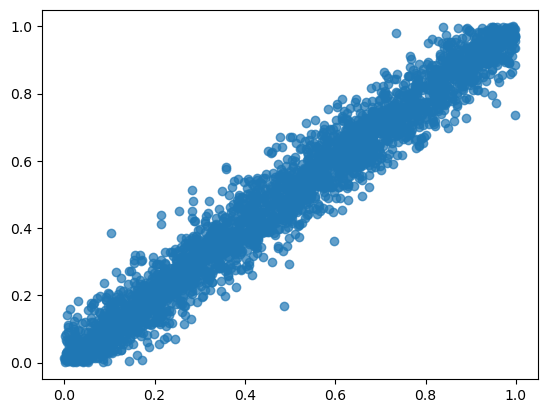

In [110]:
plt.scatter(u, v, alpha=0.7)